In [380]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm, t, ttest_1samp, ttest_rel, ttest_ind, zscore
import matplotlib.pyplot as plt

### Population Distribution

In [2]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.power(x - position, 2.) / (2 * np.power(deviation, 2.))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y:
            return x
        return generateDistribution(function)
    else:
        return np.array([generateDistribution(function) for _ in range(size)])

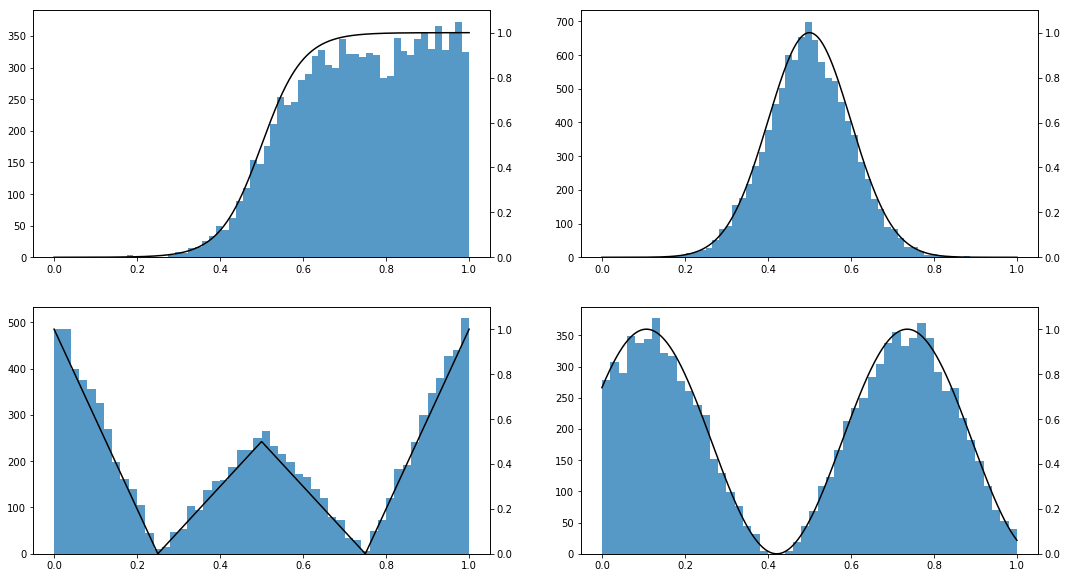

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
    #ax2.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Sampling Distribution

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

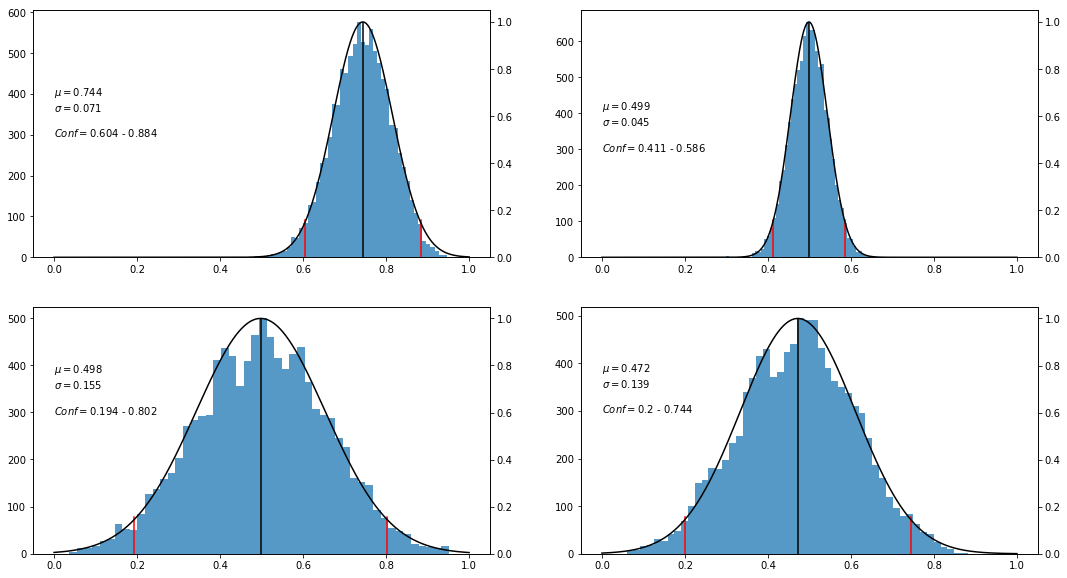

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

### Z & T scores

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [7]:
ZSCORE = 1.96
print 'Get Z-score from p-statistic: ', norm.ppf(.975)
print 'Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE)
print 
print 'Get CI from p-statistic: ', norm.interval(0.95)

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [8]:
TSCORE = 1.65
DF = 999
print 'Get T-score from p-statistic: ', t.ppf(.95, DF)
print 'Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF)
print
print 'Get CI/critical values from p-statistic: ', t.interval(0.95, DF)

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


In [930]:
def plotGauss(mu0, se, cv, mean, title, apa=''):
    fig = plt.figure(figsize=(18, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.1)
    plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    
    # Sample mean
    plt.axvline(x=mean, color='r', ymax=gauss(mean, mu0, se)*0.9)
    plt.text(mean, gauss(mean, mu0, se)+.1, r'$\overline{x} =$' + str(round(mean, 3)))

    # Critical values
    ci = mu0 + cv * se
    plt.axvline(ci.item(0), color='r', ymax=gauss(ci.item(0), mu0, se)*0.9)
    plt.text(ci.item(0), 0.23, r'$cv =$' + str(round(ci.item(0), 3)))
    if ci.size == 2:
        plt.axvline(ci[1], color='r', ymax=gauss(ci[1], mu0, se)*0.9)
        plt.text(ci[1], 0.23, r'$cv =$' + str(round(ci[1], 3)))
    
    # Standard errors
    for i in np.linspace(-3, 3, 7):
        plt.axvline(i*se+mu0, color='k', ymax=gauss(i*se+mu0, mu0, se)*0.9)
    
    plt.text(mu0, 1.04, r'$\mu_0 =$' + str(round(mu0, 3)))
    plt.text(mu0+se, 0.68, r'$\sigma =$' + str(round(se, 3)))
    plt.text(mu0+(-4*se), 0.9, apa)

    plt.title(title)
    plt.show()
    
def apa(df, T, p, kind):
    s = 't('+ str(df)+') = ' + str(round(T, 2))
    s += ', p = ' + str(round(p, 2)) + ', ' + kind
    return s

### One-sampled Z-test
Is there a significant difference between a sample and a given population distribution.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
z &= \frac{  {\overline{x} - \mu_0}}{{\sigma}}
\end{align}

In [931]:
# Descriptive statistics
sample = norm.rvs(loc=7, scale=2, size=10)
mean = np.mean(sample)
mu0, sigma = 8, 2
print mean
print sample

6.67639920942
[ 4.78855139  6.65447383  8.4009016   5.38114384  5.52924359  5.43149218
  7.11975739  7.7953989   7.55007022  8.11295915]


In [932]:
# Inferential statistics
Z = (mean - mu0) / sigma
p = norm.cdf(Z)*2
cv = np.array(norm.interval(.95))
print Z, p, cv

-0.661800395292 0.508099152767 [-1.95996398  1.95996398]


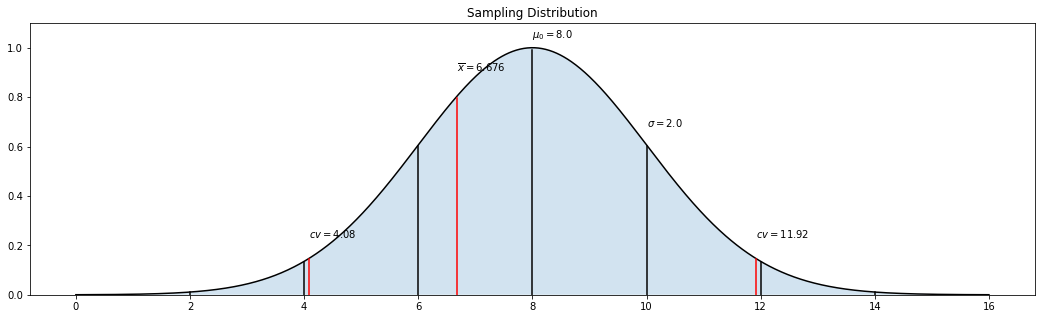

In [933]:
plotGauss(mu0, sigma, cv, mean, 'Sampling Distribution')

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}\\
d &= \frac{  {\overline{x} - \mu_0}}{s}
&&r^2 = \frac{t^2}{t^2+df}
\end{align}

In [950]:
# Descriptive statistics
sample = norm.rvs(loc=6, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print mean, sd
print sample

6.10595239618 1.602833751
[ 7.12528705  6.88273739  7.53749661  4.42898344  6.50271007  4.65984933
  5.94823813  5.0835696   4.1176149   7.85454349  7.17717386  6.86238112
  9.24053943  3.08882572  5.07933578]


In [965]:
# Inferential statistics
mu0 = 5.5
cv = np.array(t.interval(.95, n-1)) # t.ppf(.05, 24) one-tailed
se = sd / np.sqrt(n)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
print T, p, cv
print ttest_1samp(sample, mu0)

1.46418400381 1.83476492374 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=1.4145361349989396, pvalue=0.17905884821911885)


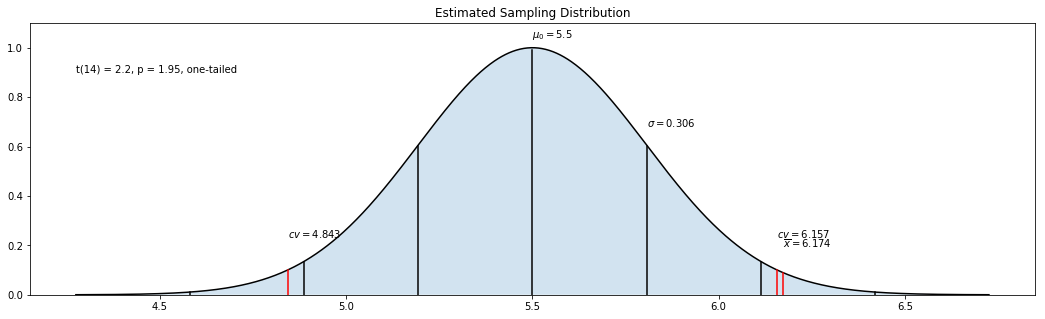

In [949]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'one-tailed'))

### Paired sampled t-test
Is there a significant difference between two dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [937]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print mean, sd
print sample

-0.269662230533 3.41789313883
[ 0.24996458 -3.50161617 -2.14567247  1.69128465  0.00743762  4.58572484
  2.96087067 -1.63678506 -3.81507069  3.04455603  6.42282108  0.63718054
 -5.13067398 -2.16467851 -5.25027657]


In [938]:
# Inferential statistics
mu0 = 0 # No difference
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
cv = np.array(t.interval(.95, n -1))
print T, p, cv
print ttest_rel(sample1, sample2)

-0.295206326186 0.772168973825 [-2.14478669  2.14478669]
Ttest_relResult(statistic=-0.29520632618570025, pvalue=0.77216897382493455)


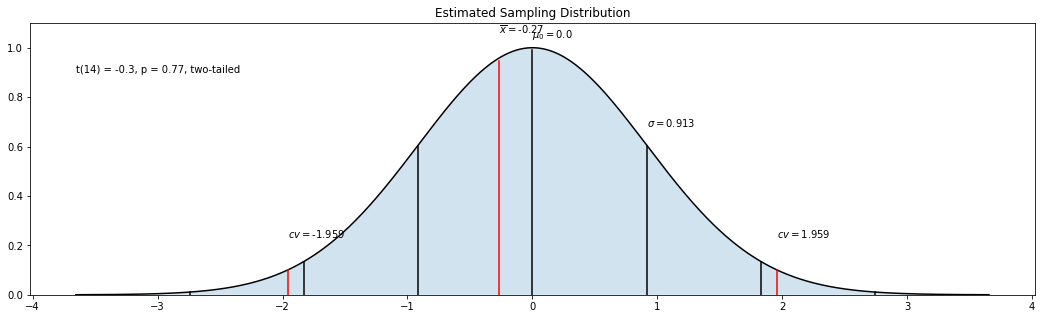

In [939]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'two-tailed'))

### Two sampled t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&\overline{y} = \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} 
&& s_y = \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}
&&s_e = s_p\sqrt{\frac{1}{n}+\frac{1}{m}}\\
t &= \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [981]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print mean1, sd1, mean2, sd2
print sample1
print sample2

6.29827634517 1.77780988729 6.64722598775 1.80395490102
[  4.09068749   6.92819557   5.53796444   7.33275217   6.21228686
   5.66099557   4.22055501   4.72825082   7.35712457   8.43650287
   4.89285127  10.06894135   4.24472772   8.93785188   5.82445759]
[ 8.2416083   3.41598749  6.02545479  3.92244127  6.47356383  8.17634184
  8.43711034  7.19927899  8.87844259  5.70203044]


In [982]:
# Inferential statistics
mu0 = 0
sp = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2))
se = sp * np.sqrt((1/float(n)+1/float(m)))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
cv = np.array(t.interval(.95, n + m - 2))
print T, p, cv
print ttest_ind(sample1, sample2)

-0.478024287082 0.637145047814 [-2.06865761  2.06865761]
Ttest_indResult(statistic=-0.45844641192380486, pvalue=0.65093421858279421)


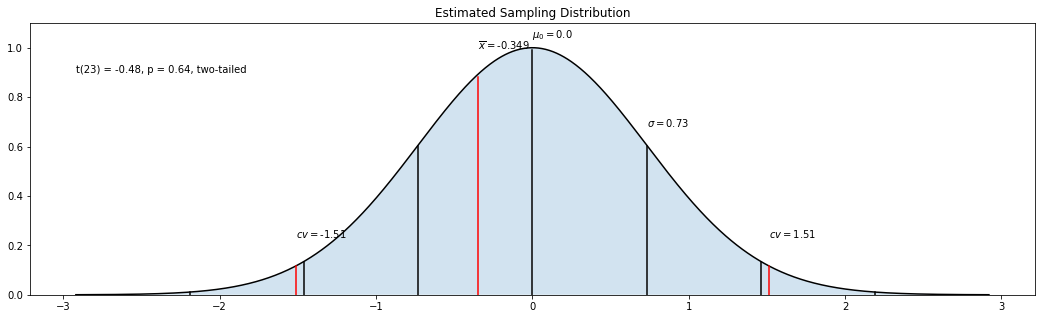

In [983]:
plotGauss(mu0, se, cv, mean1 - mean2, 'Estimated Sampling Distribution', apa(n+m-2, T, p, 'two-tailed'))

### Cohen's d and r squared

\begin{align}
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}\\
d &= \frac{  {\overline{x} - \overline{y}}} {s_p}\\
r^2 &= \frac{t^2}{t^2+df}
\end{align}